In [412]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

In [413]:
def feature_score(base, feature, base_val, feature_val, n_estimators=100, max_depth=5):
    df = pd.concat([base, feature],axis=1)
    df_val = pd.concat([base_val, feature_val],axis=1) 
    #index = int(df.shape[0]*ratio)

    x_train, y_train = df.iloc[:,1:], df.iloc[:,0]
    x_val, y_val = df_val.iloc[:,1:], df_val.iloc[:,0]
    
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    return(mean_squared_error(y_pred, y_val))

In [414]:
def forward_feature(original_count, original_count_val, data_sst, data_sst_val, link, V, tau, n_estimators=100, max_depth=5):
    result = []
    link_list = []
    start_lag = tau
    end_lag = tau + 11
    
    df = pd.DataFrame({"drought":original_count})
    df = ff.shift_df(df, start_lag, end_lag)

    x_train, y_train = df.iloc[:,1:], df.iloc[:,0]

    df_val = pd.DataFrame({"drought":original_count_val})
    df_val = ff.shift_df(df_val, start_lag, end_lag)

    x_val, y_val = df_val.iloc[:,1:], df_val.iloc[:,0]

    base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    base_model.fit(x_train, y_train);

    y_pred = base_model.predict(x_val)
    result.append(mean_squared_error(y_pred, y_val))
    
    df = pd.DataFrame({"drought": original_count})
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    for k in range(len(link)):
        df_sst["pc"] = V[:,link[k,0]-1]
        df[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst)
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    
    
    base = df.iloc[:,:13].copy()
    features = df.iloc[:,13:].copy()

    df_val = pd.DataFrame({"drought": original_count_val})
    lags = np.arange(start_lag,end_lag + 1)
    df_val = df_val.assign(**{
    '{} (t-{})'.format(col, t): df_val[col].shift(t)
    for t in lags
    for col in df_val
    })
    for k in range(len(link)):
        df_sst["pc"] = V[:,link[k,0]-1]
        df_val[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_val)
        df_val[str(k)] = df_val[str(k)].shift(abs(link[k,1]))
    df_val = df_val.dropna()

    base_val = df_val.iloc[:,:13].copy()
    features_val = df_val.iloc[:,13:].copy()
    
    while features.shape[1]>0:
        min_mse = np.Inf
        min_index = 0
        for c in features.columns:
            mse = feature_score(base, features[c], base_val, features_val[c])
            if (result[-1] > mse) and (min_mse > mse):
                min_mse = mse
                min_index = c
        if isinstance(min_index, int): break
        result.append(min_mse)
        base = pd.concat([base, features[min_index]],axis=1)
        features = features.drop(min_index,1)
        base_val = pd.concat([base_val, features_val[min_index]],axis=1)
        features_val = features_val.drop(min_index,1)
        link_list.append(link[int(min_index)])
    
    return(np.array(link_list), result)


In [415]:
def model_generator(count, data_sst, best_link, df_sst, V, tau, n_estimators=100, max_depth=5):
    
    start_lag = tau
    end_lag = tau+11
    
    df = pd.DataFrame({"drought":count})
    df = ff.shift_df(df, start_lag, end_lag)
    x_train = df.iloc[:,1:]
    y_train = df.iloc[:,0]
    base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    base_model.fit(x_train, y_train)        
            
    df = pd.DataFrame({"drought": count})
    lags = np.arange(start_lag,end_lag+1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    for k in range(len(best_link)):
        df_sst["pc"] = V[:,best_link[k,0]-1]
        df[str(k)] = ff.time_series_maker(best_link[k,0]-1, df_sst, data_sst)
        df[str(k)] = df[str(k)].shift(abs(best_link[k,1]))
    df = df.dropna()
        
    x_train = df.iloc[:,1:]
    y_train = df.iloc[:,0]
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
        
    return(base_model, model)

In [365]:
def base_model_result(count, base_model, tau=1):
    start_lag = tau
    end_lag = tau + 11
    df = pd.DataFrame({"drought":count})
    df = ff.shift_df(df, start_lag, end_lag)

    x_test, y_test = df_test.iloc[:,1:], df_test.iloc[:,0]
    y_pred = base_model.predict(x_test)

    return(y_pred, y_test)

In [366]:
def model_result(count, data_sst, link, df_sst, V, model, tau=-1, n_estimators=100, max_depth=5):
    if len(link) > 0:
        start_lag = tau
        end_lag = tau + 11

        df = pd.DataFrame({"drought":count})
        lags = np.arange(start_lag,end_lag + 1)
        df = df.assign(**{
        '{} (t-{})'.format(col, t): df[col].shift(t)
        for t in lags
        for col in df
        })
        for k in range(len(link)):
            df_sst["pc"] = V[:,link[k,0]-1]
            df[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst)
            df[str(k)] = df[str(k)].shift(abs(link[k,1]))
        df = df.dropna()

        x_test = df.iloc[:,1:]
        y_test = df.iloc[:,0]

        y_pred = model.predict(x_test)
        return(y_pred, y_test)
    else:
        return(np.nan, np.nan)


In [416]:
tau = 1
n_components_sst = 87
start_lag = tau
end_lag = tau+11
max_depth = 5
n_estimators = 100

In [368]:
link_caus = np.load("../../whole_data_results/link_rotated_ET/link_all_1930_2000_{}.npy".format(tau))
link_corr = np.load("../../whole_data_results/link_rotated_ET/link_all_corr_1930_2000_{}.npy".format(tau))

In [69]:
link_caus = np.load("../../whole_data_results/link_ET_all/link_12_1930_2000_{}_98.npy".format(tau))
link_corr = np.load("../../whole_data_results/link_ET_all/link_corr_12_1930_2000_{}_98.npy".format(tau))

In [191]:
class_list = np.load("../npy_files/ET_class_list.npy")
class_name = "BSh"
index = (np.array(class_list) == class_name)

In [444]:
train_start = 1976
train_end = 2000

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(train_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",train_start,train_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)

In [443]:
stats.pearsonr(original_count[1:], ts[:-1,3])

(-0.08965282318487433, 0.008876601128429274)

In [445]:
stats.pearsonr(original_count[1:], ts[:-1,3])

(-0.07292630458413729, 0.20860644414712579)

In [370]:
val_start = 2001
val_end = 2005

temporal_limits_val = {"time_min":datetime(val_start, 1, 1, 0, 0),"time_max":datetime(val_end, 12, 1, 0, 0)}
data_sst_val = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_val, avg, std, 12, -9.96921e+36)
original_count_val, count_val = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",val_start,val_end)

In [371]:
test_start = 2006
test_end = 2010

temporal_limits_test = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
original_count_test, count_test = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",test_start,test_end)

In [372]:
Vc = V.copy()

In [378]:
tau

1

In [374]:
link = link_caus

In [375]:
l, r = forward_feature(original_count, original_count_val, data_sst, data_sst_val, link, V, tau)

In [376]:
best_link = l

In [377]:
l

array([[ 49, -12],
       [ 69,  -9],
       [ 44,  -2],
       [ 27,  -1],
       [ 87,  -5],
       [ 83, -10],
       [ 14, -12],
       [ 37,  -5]])

In [295]:
l

array([[ 37, -12],
       [ 83, -13],
       [ 25, -18],
       [ 83, -12],
       [  7, -18],
       [  2, -18],
       [ 48, -13],
       [ 31, -12],
       [ 53, -12]])

In [266]:
#For tau = 12 and components of 87

array([[ 37, -12],
       [ 83, -13],
       [ 25, -18],
       [ 83, -12],
       [  7, -18],
       [  2, -18],
       [ 48, -13],
       [ 31, -12],
       [ 53, -12]])

In [314]:
np.load("../../whole_data_results/link_finder/spi12/best_link_all_1930_2000_{}.npy".format(tau))

array([[ 37, -12],
       [ 83, -13],
       [ 25, -18],
       [ 83, -12],
       [  7, -18],
       [  2, -18],
       [ 48, -13],
       [ 31, -12],
       [ 53, -12]])

In [345]:
best_link = np.load("../../whole_data_results/link_finder/spi12/best_link_all_1930_2000_{}.npy".format(tau))

In [200]:
best_link

array([[ 49, -12],
       [  4,  -7],
       [ 69,  -9],
       [ 27,  -1],
       [ 20,  -5],
       [ 14, -12],
       [ 37,  -5],
       [ 20,  -9]])

In [219]:
best_link

array([[ 49, -12],
       [  4,  -7],
       [ 69,  -9],
       [ 27,  -1],
       [ 20,  -5],
       [ 14, -12],
       [ 37,  -5],
       [ 20,  -9]])

In [269]:
best_link

array([[ 37, -12],
       [ 83, -13],
       [ 25, -18],
       [ 83, -12],
       [  7, -18],
       [  2, -18],
       [ 48, -13],
       [ 31, -12],
       [ 53, -12]])

In [197]:
best_link1 = best_link.copy()

In [199]:
best_link1

array([[  7,  -3],
       [ 86,  -3],
       [ 63, -10],
       [ 40,  -9],
       [ 73,  -7],
       [ 95,  -5],
       [ 26,  -8],
       [ 40,  -1]])

In [35]:
best_link

array([[  7,  -3],
       [ 95,  -5],
       [ 63, -10],
       [  2,  -7],
       [ 77,  -5],
       [  6,  -1],
       [ 72,  -3]])

In [294]:
r

[1319.1028429876462,
 1101.279533678752,
 983.2087567080001,
 880.5084147456777,
 831.2133577952143,
 798.0146988714893,
 776.2888526862916,
 737.8597522237484,
 729.2799313169061,
 684.6835385431983]

In [379]:
end_lag

12

In [380]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(val_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",train_start,val_end)
data_sst, ts, V , df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)

In [391]:
base, m = model_generator(original_count, data_sst, best_link, df_sst, V, tau)

In [409]:
df = pd.DataFrame({"drought":original_count})
df = ff.shift_df(df, start_lag, end_lag)

x_train, y_train = df.iloc[:,1:], df.iloc[:,0]

df_test = pd.DataFrame({"drought":original_count_test})
df_test = ff.shift_df(df_test, start_lag, end_lag)

x_test, y_test = df_test.iloc[:,1:], df_test.iloc[:,0]

base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
base_model.fit(x_train, y_train);

y_pred = base_model.predict(x_test)
mean_squared_error(y_pred, y_test)

267.8521566661802

In [411]:
df_test

,drought,drought (t-1),drought (t-2),drought (t-3),drought (t-4),drought (t-5),drought (t-6),drought (t-7),drought (t-8),drought (t-9),drought (t-10),drought (t-11),drought (t-12)
12,2,17.0,19.0,18.0,34.0,7.0,13.0,23.0,29.0,30.0,30.0,33.0,33.0
13,1,2.0,17.0,19.0,18.0,34.0,7.0,13.0,23.0,29.0,30.0,30.0,33.0
14,0,1.0,2.0,17.0,19.0,18.0,34.0,7.0,13.0,23.0,29.0,30.0,30.0
15,1,0.0,1.0,2.0,17.0,19.0,18.0,34.0,7.0,13.0,23.0,29.0,30.0
16,0,1.0,0.0,1.0,2.0,17.0,19.0,18.0,34.0,7.0,13.0,23.0,29.0
17,0,0.0,1.0,0.0,1.0,2.0,17.0,19.0,18.0,34.0,7.0,13.0,23.0
18,0,0.0,0.0,1.0,0.0,1.0,2.0,17.0,19.0,18.0,34.0,7.0,13.0
19,1,0.0,0.0,0.0,1.0,0.0,1.0,2.0,17.0,19.0,18.0,34.0,7.0
20,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,17.0,19.0,18.0,34.0
21,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,17.0,19.0,18.0


In [393]:
y_pred = base.predict(x_test)
mean_squared_error(y_pred, y_test)

267.8521566661802

In [394]:
def base_model_result(count, base_model, link, tau=-1):
    start_lag = tau
    end_lag = tau + 11
    df = pd.DataFrame({"drought":count})
    df = ff.shift_df(df, start_lag, end_lag)

    x_test =  df.iloc[:,1:].values
    y_test = df.iloc[:,0].values

    y_pred = base_model.predict(x_test)

    return(y_pred, y_test)

In [395]:
y_pred, y_test = base_model_result(original_count_test, base, best_link,tau)
mean_squared_error(y_pred, y_test)

267.8521566661802

In [334]:
best_link

array([[ 49, -12],
       [  4,  -7],
       [ 69,  -9],
       [ 27,  -1],
       [ 20,  -5],
       [ 14, -12],
       [ 37,  -5],
       [ 20,  -9]])

In [406]:
tau

1

In [291]:
V = Vc

In [396]:
df = pd.DataFrame({"drought": original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(best_link)):
    df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df_sst["pc"] = V[:,best_link[k,0]-1]
    #df[str(k)] = ff.time_series_maker(best_link[k,0]-1, df_sst, data_sst)
    #df[str(k)] = df[str(k)].shift(abs(best_link[k,1]))
df = df.dropna()

x_train, y_train = df.iloc[:,1:], df.iloc[:,0]

model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
model.fit(x_train, y_train);

df_test = pd.DataFrame({"drought": original_count_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(best_link)):
    #df_test[str(k)] = ff.time_series_maker_V(data_sst_test, V[:,link[k,0]-1])
    #df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
    df_sst["pc"] = V[:,best_link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(best_link[k,0]-1, df_sst, data_sst_test)
    df_test[str(k)] = df_test[str(k)].shift(abs(best_link[k,1]))
df_test = df_test.dropna()

x_test, y_test = df_test.iloc[:,1:], df_test.iloc[:,0]


In [397]:
y_pred = model.predict(x_test)
mean_squared_error(y_pred, y_test)

261.5551214337309

In [388]:
def model_result(count, data_sst, link, df_sst, V,model, tau=1, n_estimators=100, max_depth=5):
    if len(link) > 0:
        start_lag = tau
        end_lag = tau + 11

        df = pd.DataFrame({"drought":count})
        lags = np.arange(start_lag,end_lag + 1)
        
        df = df.assign(**{
        '{} (t-{})'.format(col, t): df[col].shift(t)
        for t in lags
        for col in df
        })
        for k in range(len(link)):
            df_sst["pc"] = V[:,link[k,0]-1]
            df[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst)
            df[str(k)] = df[str(k)].shift(abs(link[k,1]))
        df = df.dropna()

        x_test = df.iloc[:,1:]
        y_test = df.iloc[:,0]

        y_pred = model.predict(x_test)
        return(y_pred, y_test)
    else:
        return(np.nan, np.nan)


In [389]:
y_pred, y_test = model_result(original_count_test, data_sst_test, best_link, df_sst, V ,m, tau)
mean_squared_error(y_pred, y_test)

279.27052987403323

In [309]:
data_sst_val.shape

(120, 10988)

In [311]:
data_sst_test.shape

(60, 10988)

In [250]:
result = []
for tau in np.arange(1,13):
    pred = np.load("../../whole_data_results/results/spi12/pred_all_2011_2015_{}.npy".format(tau))
    test = np.load("../../whole_data_results/results/spi12/test_all_2011_2015_{}.npy".format(tau))
    result.append(mean_squared_error(pred, test))

In [246]:
#result = np.sqrt(result)/303

In [252]:
result_base = []
for tau in np.arange(1,13):
    pred = np.load("../../whole_data_results/results/spi12/pred_base_all_2011_2015_{}.npy".format(tau))
    test = np.load("../../whole_data_results/results/spi12/test_base_all_2011_2015_{}.npy".format(tau))
    result_base.append(mean_squared_error(pred, test))

In [248]:
result_base = np.sqrt(result_base)/303

In [253]:
result_base

[82.02159063307798,
 255.31742661694028,
 574.1325182478246,
 883.2508220153633,
 1057.691906026736,
 1117.9014602694829,
 1348.1162211062206,
 1322.555426030099,
 1548.9810932511919,
 1750.8488650751488,
 2070.238065425716,
 2199.392057962592]

In [251]:
result

[113.6589618822751,
 289.0173763988031,
 697.1300809957195,
 906.4977000692725,
 972.0975427778422,
 1264.1819209381745,
 1304.8724753394497,
 1468.7112826034845,
 2478.004312588626,
 2102.76008897911,
 2444.382313281672,
 2375.454533098977]

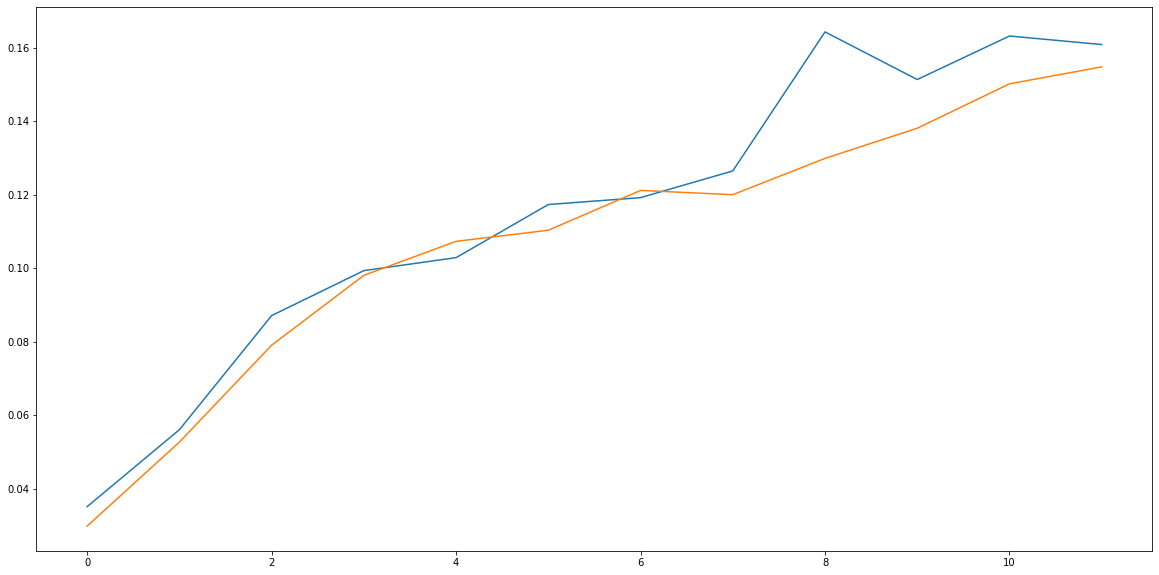

In [104]:
x = np.arange(len(result))
plt.plot(x,result,x,result_base)

In [62]:
result = []
link_list = []
start_lag = tau
end_lag = tau + 11
n_estimators=100
max_depth=5

In [63]:
df = pd.DataFrame({"drought":original_count})
df = ff.shift_df(df, start_lag, end_lag)

x_train, y_train = df.iloc[:,1:], df.iloc[:,0]

In [64]:
df_val = pd.DataFrame({"drought":original_count_val})
df_val = ff.shift_df(df_val, start_lag, end_lag)

x_val, y_val = df_val.iloc[:,1:], df_val.iloc[:,0]

In [65]:
base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
base_model.fit(x_train, y_train);

In [66]:
y_pred = base_model.predict(x_val)
result.append(mean_squared_error(y_pred, y_val))

In [67]:
result

[160.10574334929868]

In [302]:
df = pd.DataFrame({"drought": original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(link)):
    #df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    #df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df_sst["pc"] = V[:,link[k,0]-1]
    df[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst)
    df[str(k)] = df[str(k)].shift(abs(link[k,1]))
df = df.dropna()

base = df.iloc[:,:13].copy()
features = df.iloc[:,13:].copy()

In [303]:
df_val = pd.DataFrame({"drought": original_count_val})
lags = np.arange(start_lag,end_lag + 1)
df_val = df_val.assign(**{
'{} (t-{})'.format(col, t): df_val[col].shift(t)
for t in lags
for col in df_val
})
for k in range(len(link)):
    df_sst["pc"] = V[:,link[k,0]-1]
    df_val[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_val)
    df_val[str(k)] = df_val[str(k)].shift(abs(link[k,1]))
df_val = df_val.dropna()

base_val = df_val.iloc[:,:13].copy()
features_val = df_val.iloc[:,13:].copy()

In [304]:
def feature_score(base, feature, base_val, feature_val, n_estimators=100, max_depth=5):
    df = pd.concat([base, feature],axis=1)
    df_val = pd.concat([base_val, feature_val],axis=1) 
    #index = int(df.shape[0]*ratio)

    x_train, y_train = df.iloc[:,1:], df.iloc[:,0]
    x_val, y_val = df_val.iloc[:,1:], df_val.iloc[:,0]
    
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    return(mean_squared_error(y_pred, y_val))

In [305]:
while features.shape[1]>0:
    min_mse = np.Inf
    min_index = 0
    for c in features.columns:
        mse = feature_score(base, features[c], base_val, features_val[c])
        if (result[-1] > mse) and (min_mse > mse):
            min_mse = mse
            min_index = c
    if isinstance(min_index, int): break
    result.append(min_mse)
    base = pd.concat([base, features[min_index]],axis=1)
    features = features.drop(min_index,1)
    base_val = pd.concat([base_val, features_val[min_index]],axis=1)
    features_val = features_val.drop(min_index,1)
    link_list.append(link[int(min_index)])

In [306]:
link_list

[array([ 37, -12]),
 array([ 83, -13]),
 array([ 25, -18]),
 array([ 83, -12]),
 array([  7, -18]),
 array([  2, -18]),
 array([ 48, -13]),
 array([ 31, -12]),
 array([ 53, -12])]

In [307]:
result

[1319.1028429876462,
 1101.279533678752,
 983.2087567080001,
 880.5084147456777,
 831.2133577952143,
 798.0146988714893,
 776.2888526862916,
 737.8597522237484,
 729.2799313169061,
 684.6835385431983]

In [56]:
link_list

[array([ 11, -17]),
 array([ 33, -20]),
 array([ 22, -17]),
 array([  7, -22]),
 array([ 11, -14]),
 array([  5, -15]),
 array([ 52, -16]),
 array([ 39, -17])]

In [57]:
result

[1319.1028429876462,
 1202.7095608659129,
 1159.783139468003,
 1130.431605537738,
 1104.8273252330673,
 1101.8139287998545,
 1091.468353027205,
 1083.1310072113597,
 1081.0397756033483]

In [145]:
l

array([[ 74, -12],
       [ 40, -12],
       [ 46, -18],
       [  4, -21],
       [ 25, -19],
       [ 11, -23],
       [ 47, -15],
       [ 25, -17]])

In [38]:
link_list

[array([ 74, -12]),
 array([ 15, -21]),
 array([ 86, -21]),
 array([ 81, -13]),
 array([ 46, -15]),
 array([ 50, -13]),
 array([ 78, -16]),
 array([  2, -20]),
 array([ 98, -23])]

In [39]:
result

[1319.1028429876462,
 1050.9921668418306,
 974.9414948137519,
 912.2021775375831,
 870.7395367277998,
 840.3332341529032,
 808.7885683520061,
 780.1320369437708,
 764.7519484046292,
 756.4666002296735]

In [59]:
link_list = [[ 74, -12],[ 15, -21],
 [ 86, -21],
 [ 81, -13],
 [ 46, -15],
 [ 50, -13],
 [ 78, -16],
 [  2, -20],
 [ 98, -23]]

In [73]:
best_link = np.array(link_list)

In [123]:
tau

12

In [179]:
best_link

array([[ 37, -12],
       [ 83, -13],
       [ 25, -18],
       [ 83, -12],
       [  7, -18],
       [  2, -18],
       [ 48, -13],
       [ 31, -12],
       [ 53, -12]])

In [158]:
best_link = l

In [131]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(val_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",train_start,val_end)
data_sst, ts, V , df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)

In [132]:
df = pd.DataFrame({"drought":original_count})
df = ff.shift_df(df, start_lag, end_lag)

x_train, y_train = df.iloc[:,1:], df.iloc[:,0]

In [133]:
df_test = pd.DataFrame({"drought":original_count_test})
df_test = ff.shift_df(df_test, start_lag, end_lag)

x_test, y_test = df_test.iloc[:,1:], df_test.iloc[:,0]

In [136]:
base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
base_model.fit(x_train, y_train);

y_pred = base_model.predict(x_test)
mean_squared_error(y_pred, y_test)

82.02159063307798

1868.1025306776066

In [200]:
r

[1319.1028429876462,
 1101.279533678752,
 983.2087567080001,
 880.5084147456777,
 831.2133577952143,
 798.0146988714893,
 776.2888526862916,
 737.8597522237484,
 729.2799313169061,
 684.6835385431983]

In [202]:
#base_model_result(original_count_test, b, tau)

In [137]:
df = pd.DataFrame({"drought": original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(best_link)):
    #df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    #df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df_sst["pc"] = V[:,best_link[k,0]-1]
    df[str(k)] = ff.time_series_maker(best_link[k,0]-1, df_sst, data_sst)
    df[str(k)] = df[str(k)].shift(abs(best_link[k,1]))
df = df.dropna()

x_train, y_train = df.iloc[:,1:], df.iloc[:,0]

model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
model.fit(x_train, y_train);

In [138]:
df_test = pd.DataFrame({"drought": original_count_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(best_link)):
    #df_test[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    #df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
    df_sst["pc"] = V[:,best_link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(best_link[k,0]-1, df_sst, data_sst_test)
    df_test[str(k)] = df_test[str(k)].shift(abs(best_link[k,1]))
df_test = df_test.dropna()

x_test, y_test = df_test.iloc[:,1:], df_test.iloc[:,0]



In [139]:
y_pred = model.predict(x_test)
mean_squared_error(y_pred, y_test)

81.76578448430591

In [140]:
y_pred = m.predict(x_test)
mean_squared_error(y_pred, y_test)

81.76578448430591

In [207]:
r

[1319.1028429876462,
 1101.279533678752,
 983.2087567080001,
 880.5084147456777,
 831.2133577952143,
 798.0146988714893,
 776.2888526862916,
 737.8597522237484,
 729.2799313169061,
 684.6835385431983]

In [82]:
math.sqrt(1524)/303

0.12883974452767746

In [83]:
math.sqrt(2199)/303

0.15476401435898818

In [19]:
link_list

[array([ 7, -3]),
 array([86, -3]),
 array([ 63, -10]),
 array([40, -9]),
 array([73, -7]),
 array([95, -5]),
 array([26, -8]),
 array([40, -1])]

In [20]:
result

[288.67583732502163,
 271.3785553338698,
 253.2389522828555,
 246.59468575446846,
 239.70305104114522,
 237.55003947612022,
 230.79977026507407,
 227.70897095039092,
 222.63137236958852]

In [21]:
df_sst

,lons,lats,pc
0,0.0,88.0,NaN
1,0.0,86.0,NaN
2,0.0,84.0,NaN
3,0.0,82.0,NaN
4,0.0,80.0,NaN
...,...,...,...
10983,-2.0,-62.0,NaN
10984,-2.0,-64.0,NaN
10985,-2.0,-66.0,NaN
10986,-2.0,-68.0,NaN


In [155]:
link_list

[array([12, -6]), array([ 84, -12]), array([ 8, -7])]

In [156]:
result

[288.67583732502163, 276.8398434208238, 268.28223215111984, 258.892908056739]

In [141]:
link_list

[array([54, -4]),
 array([92, -8]),
 array([40, -9]),
 array([ 84, -12]),
 array([86, -3]),
 array([98, -9]),
 array([ 59, -12]),
 array([ 87, -11])]

In [142]:
 np.load("../../whole_data_results/link_rotated_ET/best_link_all_1930_2000_{}.npy".format(tau))

array([[ 73,  -1],
       [ 54,  -4],
       [ 95,  -5],
       [ 56, -12],
       [ 70,  -9],
       [ 57,  -7],
       [  7,  -3]])

In [143]:
result

[288.67583732502163,
 271.3889583401474,
 262.0091439555347,
 255.13429840251408,
 251.1191158656034,
 250.6312310256766,
 247.8699569671881,
 246.30396615566238,
 242.55459104265896]

In [127]:
base

,drought,drought (t-1),drought (t-2),drought (t-3),drought (t-4),drought (t-5),drought (t-6),drought (t-7),drought (t-8),drought (t-9),drought (t-10),drought (t-11),drought (t-12),10
12,23,24.0,24.0,23.0,11.0,1.0,7.0,1.0,0.0,4.0,6.0,7.0,25.0,-1.374026
13,25,23.0,24.0,24.0,23.0,11.0,1.0,7.0,1.0,0.0,4.0,6.0,7.0,3.683157
14,25,25.0,23.0,24.0,24.0,23.0,11.0,1.0,7.0,1.0,0.0,4.0,6.0,-3.105318
15,26,25.0,25.0,23.0,24.0,24.0,23.0,11.0,1.0,7.0,1.0,0.0,4.0,1.271245
16,79,26.0,25.0,25.0,23.0,24.0,24.0,23.0,11.0,1.0,7.0,1.0,0.0,2.165204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,84,62.0,62.0,86.0,103.0,64.0,64.0,63.0,69.0,67.0,78.0,76.0,61.0,1.996249
848,84,84.0,62.0,62.0,86.0,103.0,64.0,64.0,63.0,69.0,67.0,78.0,76.0,-5.317979
849,79,84.0,84.0,62.0,62.0,86.0,103.0,64.0,64.0,63.0,69.0,67.0,78.0,-8.649045
850,74,79.0,84.0,84.0,62.0,62.0,86.0,103.0,64.0,64.0,63.0,69.0,67.0,-6.487833


In [128]:
base_val

,drought,drought (t-1),drought (t-2),drought (t-3),drought (t-4),drought (t-5),drought (t-6),drought (t-7),drought (t-8),drought (t-9),drought (t-10),drought (t-11),drought (t-12)
12,14,15.0,7.0,1.0,1.0,2.0,5.0,8.0,10.0,0.0,31.0,37.0,39.0
13,9,14.0,15.0,7.0,1.0,1.0,2.0,5.0,8.0,10.0,0.0,31.0,37.0
14,9,9.0,14.0,15.0,7.0,1.0,1.0,2.0,5.0,8.0,10.0,0.0,31.0
15,6,9.0,9.0,14.0,15.0,7.0,1.0,1.0,2.0,5.0,8.0,10.0,0.0
16,16,6.0,9.0,9.0,14.0,15.0,7.0,1.0,1.0,2.0,5.0,8.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,64,64.0,62.0,78.0,84.0,102.0,133.0,115.0,154.0,102.0,126.0,92.0,109.0
116,51,64.0,64.0,62.0,78.0,84.0,102.0,133.0,115.0,154.0,102.0,126.0,92.0
117,40,51.0,64.0,64.0,62.0,78.0,84.0,102.0,133.0,115.0,154.0,102.0,126.0
118,42,40.0,51.0,64.0,64.0,62.0,78.0,84.0,102.0,133.0,115.0,154.0,102.0


In [129]:
result

[288.67583732502163, 271.3889583401474]

In [ ]:
def feature_score(base, feature, base_val, feature_val, n_estimators=100, max_depth=5):
    df = pd.concat([base, feature],axis=1)
    df_val = df = pd.concat([base_val, feature_val],axis=1) 
    #index = int(df.shape[0]*ratio)

    x_train, y_train = df.iloc[:,1:], df.iloc[:,1]
    x_val, y_val = df_val.iloc[:,1:], df_val.iloc[:,1]
    
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    return(mean_squared_error(y_pred, y_val))
    

def forward_feature_V(count, data_sst, link, V, tau,  ratio = 0.8, n_estimators=100, max_depth=5):
    result = []
    link_list = []
    start_lag = tau
    end_lag = tau + 11
    df = pd.DataFrame({"drought":count})
    
    df = shift_df(df, start_lag, end_lag)
    index = int(df.shape[0]*ratio)
    dim = df.shape[1]
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim]
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0]
    base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    base_model.fit(x_train, y_train)
    y_pred = base_model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))
    
    df = pd.DataFrame({"drought": count})
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    for k in range(len(link)):
        df[str(k)] = time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
    
    base = df.iloc[:,:14].copy()
    features = df.iloc[:,14:].copy()
    
    while features.shape[1]>0:
        min_mse = np.Inf
        min_index = 0
        for c in features.columns:
            mse = feature_score(base, features[c])
            if (result[-1] > mse) and (min_mse > mse):
                min_mse = mse
                min_index = c
        if isinstance(min_index, int): break
        result.append(min_mse)
        base = pd.concat([base, features[min_index]],axis=1)
        features = features.drop(min_index,1)
        link_list.append(link[int(min_index)])
            
    if len(link_list) > 0:        
        x_train = base.iloc[:,1:]
        y_train = base.iloc[:,0]
        model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
        model.fit(x_train, y_train)
    else:
        model = base_model
        link_list = []
    
    return(np.array(link_list),base_model, model)